![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.3.Clinical_Deidentification_Comparison.ipynb)

# Comparison of different Deidentification Libraries
In this notebook we will include a comparison of the deidentification capabilities of different libraries on same clinical notes (n2C2 Deidentification dataset).

The tested libraries are:
- Spark NLP for Healthcare (deidentification pipelines)
- Scrubadub + Scrubadub with Spacy Transformers
- (more coming soon!)

# Installation

In [ ]:
!pip install scrubadub scrubadub_spacy spacy_transformers

## Spark NLP for Healthcare License

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
import os
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare-3.3.4.json to spark_nlp_for_healthcare-3.3.4 (1).json


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

In [ ]:
# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Starting a Spark NLP for Healthcare session

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
import xml.etree.ElementTree as ET

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
import pprint 
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.3.4
Spark NLP_JSL Version : 3.3.4


# Download some clinical notes from N2C2

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/tutorials/Certification_Trainings/Healthcare/data/deid_surrogate_test_all_groundtruth_version2.xml

# Parsing the XML

In [ ]:
tree = ET.parse('deid_surrogate_test_all_groundtruth_version2.xml')
root = tree.getroot()

# Retrieving texts and PHI fields

In [ ]:
import re
data = []
for r in root.findall('RECORD'):
    for t in r.findall('TEXT'):
        children = []
        for c in t.getchildren():
            children.append((c.text, c.attrib['TYPE']))
        text = "".join([ t.text ] + [ ET.tostring(e).decode('utf-8') for e in t.getchildren()])
        unmasked_text = re.sub(r"<PHI [^>]*>", "", text)
        unmasked_text = re.sub(r"</PHI>", "", unmasked_text)
        data.append({'unmasked_text': unmasked_text, 'text': text, 'phi': children})

In [ ]:
# Printing data[0], that contains the information of the first clinical note.
print(data[0]['unmasked_text'])


113416550
PRGH
13523357
630190
6/7/1999 12:00:00 AM
Discharge Summary
Signed
DIS
Admission Date :
06/07/1999
Report Status :
Signed
Discharge Date :
06/13/1999
HISTORY OF PRESENT ILLNESS :
Essentially , Mr. Cornea is a 60 year old male who noted the onset of dark urine during early January .
He underwent CT and ERCP at the Lisonatemi Faylandsburgnic, Community Hospital with a stent placement and resolution of jaundice .
He underwent an ECHO and endoscopy at Ingree and Ot of Weamanshy Medical Center on April 28 .
He was found to have a large , bulging , extrinsic mass in the lesser curvature of his stomach .
Fine needle aspiration showed atypical cells , positively reactive mesothelial cells .
Abdominal CT on April 14 , showed a 12 x 8 x 8 cm mass in the region of the left liver , and appeared to be from the lesser curvature of the stomach or left liver .
He denied any nausea , vomiting , anorexia , or weight loss .
He states that his color in urine or in stool is now normal .
PAST MED

In [ ]:
print(data[0]['phi'])

[('113416550', 'ID'), ('PRGH', 'HOSPITAL'), ('13523357', 'ID'), ('630190', 'ID'), ('6/7', 'DATE'), ('06/07', 'DATE'), ('06/13', 'DATE'), ('Cornea', 'PATIENT'), ('January', 'DATE'), ('Lisonatemi Faylandsburgnic, Community Hospital', 'HOSPITAL'), ('Ingree and Ot of Weamanshy Medical Center', 'HOSPITAL'), ('April 28', 'DATE'), ('April 14', 'DATE'), ('7th of June', 'DATE'), ('Kotefooksshuff', 'DOCTOR'), ('THAMETO DOYLE', 'DOCTOR'), ('OS43', 'ID'), ('PRO R. KOTEFOOKSSHUFF', 'DOCTOR'), ('RF6 ZY525/1920', 'ID'), ('69874', 'ID'), ('YFKAJTRZX9', 'ID'), ('06/13', 'DATE'), ('06/13', 'DATE'), ('KE9', 'ID')]


# Spark NLP for Healthcare (Time: 1.43s)
Let's use Spark NLP for Healthcare's Pretrained Pipeline for `clinical_deidentification`

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("clinical_deidentification_glove", "en", "clinical/models")

clinical_deidentification_glove download started this may take some time.
Approx size to download 172.9 MB
[OK!]


## `annotate()` on PretrainedPipelines uses LightPipelines, what means is optimized for speed

In [ ]:
%%time
res = deid_pipeline.annotate(data[0]['unmasked_text'])

CPU times: user 21.5 ms, sys: 3.32 ms, total: 24.8 ms
Wall time: 1.43 s


In [ ]:
for i in range(0, len(res['masked'])):
  print(res['masked'][i])

<MEDICALRECORD>
<HOSPITAL>
<MEDICALRECORD>
<MEDICALRECORD>
<DATE> 12:00:00 AM
Discharge Summary
Signed
DIS
Admission Date :
<DATE>
Report Status :
Signed
Discharge Date :
<DATE>
HISTORY OF PRESENT ILLNESS :
Essentially , Mr. <PATIENT> is a <AGE> year old male who noted the onset of dark urine during early <DATE> .
He underwent CT and ERCP at the <HOSPITAL> with a stent placement and resolution of jaundice .
He underwent an ECHO and endoscopy at <HOSPITAL> on <DATE> .
He was found to have a large , bulging , extrinsic mass in the lesser curvature of his stomach .
Fine needle aspiration showed atypical cells , positively reactive mesothelial cells .
Abdominal CT on <DATE> , showed a 12 x 8 x 8 cm mass in the region of the left liver , and appeared to be from the lesser curvature of the stomach or left liver .
He denied any nausea , vomiting , anorexia , or weight loss .
He states that his color in urine or in stool is now normal .
PAST MEDICAL HISTORY :
He has hypertension and nephrolith

In [ ]:
import re
chunks = []
for i in range(0, len(res['masked'])):
  matches = re.findall(r"<[A-Z]+>", res['masked'][i])
  chunks.extend(matches)

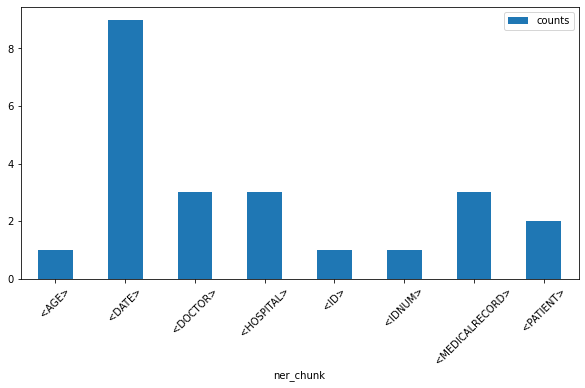

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

df = pd.DataFrame(chunks, columns=['ner_chunk'])
df_count = pd.DataFrame(df.groupby('ner_chunk').size().reset_index(name='counts'))
df_count.plot.bar(x='ner_chunk', y='counts', rot=45)

# ScrubaDub with original and Spacy Transformers (Time: 9.24s)

In [ ]:
import scrubadub, scrubadub_spacy

detector_list = [
                 scrubadub.detectors.DateOfBirthDetector,
                 scrubadub_spacy.detectors.spacy_name_title.SpacyNameDetector,
                 scrubadub_spacy.detectors.spacy.SpacyEntityDetector(named_entities=['DATE', 'FAC', 'GPE', 'LOC', 'ORG', 'PER', 'PERSON'])
]
scrubber = scrubadub.Scrubber(detector_list=detector_list)

In [ ]:
scrubadub_spacy.detectors.spacy.SpacyEntityDetector.filth_cls_map

{'DATE': scrubadub.filth.date_of_birth.DateOfBirthFilth,
 'FAC': scrubadub.filth.location.LocationFilth,
 'GPE': scrubadub.filth.location.LocationFilth,
 'LOC': scrubadub.filth.location.LocationFilth,
 'ORG': scrubadub.filth.organization.OrganizationFilth,
 'PER': scrubadub.filth.name.NameFilth,
 'PERSON': scrubadub.filth.name.NameFilth}

In [ ]:
%%time
res = scrubber.clean(data[0]['unmasked_text'])

CPU times: user 8.44 s, sys: 354 ms, total: 8.79 s
Wall time: 9.24 s


In [ ]:
res = res.replace('+ORGANIZATION', '')
res = res.replace('+NAME', '')
print(res)


113416550
PRGH
13523357
630190
6/7/1999 12:00:00 AM
Discharge Summary
Signed
DIS
Admission Date :
{{DATE_OF_BIRTH}}
Report Status :
Signed
Discharge Date :
{{DATE_OF_BIRTH}}
HISTORY OF PRESENT ILLNESS :
Essentially , {{NAME}} is a 60 year old male who noted the onset of dark urine during early January .
He underwent CT and ERCP at {{ORGANIZATION}} with a stent placement and resolution of jaundice .
He underwent an ECHO and endoscopy at {{ORGANIZATION}} on April 28 .
He was found to have a large , bulging , extrinsic mass in the lesser curvature of his stomach .
Fine needle aspiration showed atypical cells , positively reactive mesothelial cells .
Abdominal CT on April 14 , showed a 12 x 8 x 8 cm mass in the region of the left liver , and appeared to be from the lesser curvature of the stomach or left liver .
He denied any nausea , vomiting , anorexia , or weight loss .
He states that his color in urine or in stool is now normal .
PAST MEDICAL HISTORY :
He has hypertension and nephroli

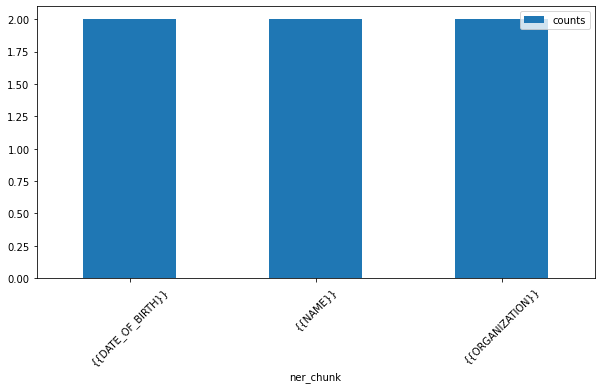

In [ ]:
chunks = re.findall(r"{{[A-Z_\+]+}}", res)
df = pd.DataFrame(chunks, columns=['ner_chunk'])
df_count = pd.DataFrame(df.groupby('ner_chunk').size().reset_index(name='counts'))
df_count.plot.bar(x='ner_chunk', y='counts', rot=45)

# COMPARISON
|                                                 	| Spark NLP for Healthcare 	| ScrubaDub + Spacy 	|
|-------------------------------------------------	|--------------------------	|-------------------	|
| Time in inference (excluding download)          	| 1.43                     	| 3.59              	|
| Relevant clinical tags included out of the box  	| Up to 28                 	| Up to 11          	|
| Matches in a sample clinical note from N2B2     	| 23                       	| 6                 	|
| Possibility of including custom NER models      	| YES (Spark NLP)          	| YES (Spacy)       	|
| Possibility of including custom rules/regex     	| YES                      	| YES               	|

More frameworks coming soon!